Code for the OpenCV disparity mapping modified from code here: https://learnopencv.com/depth-perception-using-stereo-camera-python-c/

Contours: https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html

Bounding Rectangles:
https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html

Blob detection:
https://learnopencv.com/blob-detection-using-opencv-python-c/

Depth Mapping:
https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html

In [71]:
#Point the system to the driver_base.py which live in that sys path. driver_base.py has a whole bunch of functions that are needed for the FINN overlay

import sys
sys.path.append('./deploy/driver')

## Deal with imports ##

## Setup for CNN network
from deploy.driver.driver import FINNExampleOverlay
from qonnx.core.datatype import DataType
import numpy as np
## Setup for OpenCV imports
import cv2



## Deal with any initial setup

bitfile_CNN= "deploy/bitfile/finn-accel.bit"

platform = "zynq-iodma"

#Input/output dictionary to deal with FPGA CNN
_cifar10_cnv_io_shape_dict = {
    "idt": [DataType["UINT8"]],
    "odt": [DataType["UINT8"]],
    "ishape_normal": [(1, 32, 32, 3)],
    "oshape_normal": [(1, 1)],
    "ishape_folded": [(1, 1, 32, 32, 1, 3)],
    "oshape_folded": [(1, 1, 1)],
    "ishape_packed": [(1, 1, 32, 32, 1, 3)],
    "oshape_packed": [(1, 1, 1)],
    "input_dma_name": ["idma0"],
    "output_dma_name": ["odma0"],
    "number_of_external_weights": 0,
    "num_inputs": 1,
    "num_outputs": 1,
}

accel_CNN = FINNExampleOverlay(bitfile_CNN, platform, io_shape_dict=_cifar10_cnv_io_shape_dict)

labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


In [ ]:
# TODO: Implement code to deal with stereoimage rectification and calibration. Maybe not needed for stage 1.

In [117]:
## Load in some dummy stereo parameters for testing

stereo_params = {
    "numDisparities": 16*6,
    "blockSize": 15
}

## Dummy calibration maps
#h,w = 240,320

h,w = 480,640
left_stereo_map_x = np.tile(np.arange(w),(h,1)).astype(np.float32)
left_stereo_map_y = np.tile(np.arange(h).reshape(-1,1),(1,w)).astype(np.float32)
right_stereo_map_x = left_stereo_map_x.copy()
right_stereo_map_y = left_stereo_map_y.copy()
maps = (left_stereo_map_x,left_stereo_map_y,right_stereo_map_x,right_stereo_map_y)

In [96]:
## Dummy extract roi
def extract_roi(disparity, center_x, center_y, crop_size):
    top = center_y - crop_size // 2
    left = center_x - crop_size // 2

    roi_disp = disparity[top:top + crop_size, left:left + crop_size]
    return [roi_disp]



def extract_roi_rgb(disp, rgb_image, center_x, center_y, crop_size, target_size=(32, 32)):
    top = center_y - crop_size // 2
    left = center_x - crop_size // 2

    roi_large = rgb_image[top:top + crop_size, left:left + crop_size]
    roi_resized = cv2.resize(roi_large, target_size)

    return [roi_resized]



## TODO: Implement proper ROI

In [97]:
# Code to deal with image input from stereo cameras

def computer_disparity(left_img, right_img, stereo_params, maps):
    #Setup stereo parameters and maps
    stereo = cv2.StereoBM_create()
    stereo.setNumDisparities(stereo_params['numDisparities'])
    stereo.setBlockSize(stereo_params['blockSize'])
    ## Do any other kind of setup
    
    lmx,lmy,rmx,rmy = maps
    left_nice = cv2.remap(left_img, lmx, lmy, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    right_nice = cv2.remap(right_img, rmx, rmy, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    
    disparity = stereo.compute(left_nice,right_nice).astype(np.float32)
    disparity = (disparity/16)/stereo_params['numDisparities']
    return disparity
    
def prepare_input(roi, input_shape=(32,32)):
    roi_resized = cv2.resize(roi,input_shape)
    #roi_resized = np.clip(roi_resized,0,1)
    roi_input = roi_resized.astype(np.float32).reshape(1,32,32,3)
    return roi_input

def calculate_depth(disparity_value, focal_length_px, baseline_m):
    if disparity_value > 0:
        return (focal_length_px * baseline_m / disparity_value) # This is based off of Depth map formula from openCV
    else: # We don't know what the depth is
        return "??"

In [98]:
def run_cnn_inference(image):
    output = accel_CNN.execute(image)
    print("Raw output:", output)
    return labels[int(output[0])]

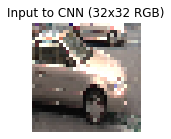

Raw output: [[1.]]
Automobile: 108.4347708453303 m


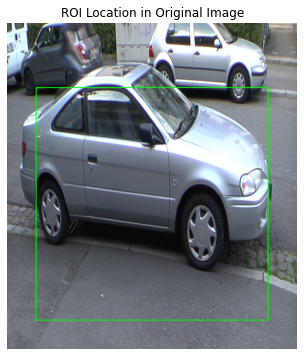

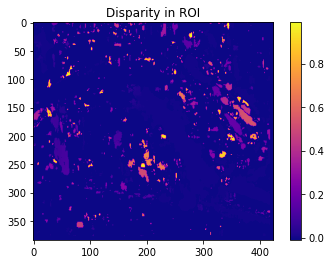

In [118]:
## Load in a dummy left and right set
imgL = cv2.imread("left.png")
imgR = cv2.imread("right.png")

## Cat test:

# imgL = cv2.imread("left_cat.png")
# imgR = cv2.imread("right_cat.png")


## Cifar validation
# Load image data
input_data = np.load("input.npy").astype(np.uint8)

imgL_CIFAR = input_data[0].reshape((1, 32, 32, 3)).astype(np.uint8)

## Convert to grayscale

imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

## Dummy calibration values
focal_length = 600 # in pixels
baseline = 0.06 # in metres

# Guess pixels for testing
x_pixel = 600
y_pixel = 480
crop_size = 128 * 6
#run pipeline

## TEST: One shot test run to see if pipeline theoretically works
disp = computer_disparity(imgL_gray, imgR_gray,stereo_params,maps)
# Try     center_y, center_x = 600, 480  # tweak these for testing
rois_rgb = extract_roi_rgb(disp,imgL,x_pixel,y_pixel, crop_size)
rois_disp = extract_roi(disp, x_pixel, y_pixel, crop_size)

for roi in rois_rgb:
    cnn_input = prepare_input(roi)
    
    ## DEBUG:See whats going into CNN
    import matplotlib.pyplot as plt
    plt.figure(figsize=(2,2))
    plt.imshow(cnn_input[0].astype(np.uint8))
    plt.title("Input to CNN (32x32 RGB)")
    plt.axis("off")
    plt.show()
    
    
    roi_disp = rois_disp[0]
    valid_disp = roi_disp[roi_disp >0]
    mean_disp = np.mean(valid_disp) if valid_disp.size > 0 else 0
    distance = calculate_depth(mean_disp,focal_length,baseline)
    #distance = calculate_depth(np.mean(disp[100:132, 100:132]), focal_length, baseline)
    result = run_cnn_inference(cnn_input)
    print(f"{result}: {distance} m")


# Debug view to check where the patch is coming from



rois_rgb = extract_roi_rgb(disp, imgL, x_pixel,y_pixel, crop_size)

top = x_pixel -crop_size // 2
left = y_pixel - crop_size //2


vis_img = imgL.copy()

#Draw rectangle
cv2.rectangle(vis_img, (left, top), (left + crop_size, top + crop_size), (0, 255, 0), 2)

# Show it with matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title("ROI Location in Original Image")
plt.axis('off')
plt.show()


import matplotlib.pyplot as plt

plt.imshow(rois_disp[0], cmap='plasma')
plt.title("Disparity in ROI")
plt.colorbar()
plt.show()


In [ ]:
## Continuous while loop for the realtime execution and pipeline. WIP

while True:
    retL, imgL = CamL.read()
    retR, imgR= CamR.read()
    
    imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BRG2GRAY)
    if retL and retR:
        disp = computer_disparity(imgL_gray, imgR_gray, stereo_params, maps)
        rois = extract_roi(disp)
        for roi in rois:
            cnn_input = prepare_input(roi)
            #np.save("input.npy", cnn_input)
            distance = calculate_depth(disparity,focal_length,baseline)
            result = run_cnn_inference(cnn_input)
            
            # Return result is distance away
            return result + ":" + " " + distance + "mm"
